# https://www.pymc.io/projects/examples/en/latest/causal_inference/interrupted_time_series.html

In [1]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from scipy.stats import norm

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")


def plot_xY(x, Y, ax):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3)


# default figure sizes
figsize = (10, 5)

In [4]:
treatment_time = "2017-01-01"
β0 = 0
β1 = 0.1
dates = pd.date_range(
    start=pd.to_datetime("2010-01-01"), end=pd.to_datetime("2020-01-01"), freq="M"
)
N = len(dates)


def causal_effect(df):
    return (df.index > treatment_time) * 2


df = (
    pd.DataFrame()
    .assign(time=np.arange(N), date=dates)
    .set_index("date", drop=True)
    .assign(y=lambda x: β0 + β1 * x.time + causal_effect(x) + norm(0, 0.5).rvs(N))
)
df

,time,y
date,,
2010-01-31,0,-0.068345
2010-02-28,1,0.487525
2010-03-31,2,1.277127
2010-04-30,3,0.606741
2010-05-31,4,0.919289
...,...,...
2019-08-31,115,15.168358
2019-09-30,116,12.544777
2019-10-31,117,13.703886


In [5]:
# Split into pre and post intervention dataframes
pre = df[df.index < treatment_time]
post = df[df.index >= treatment_time]

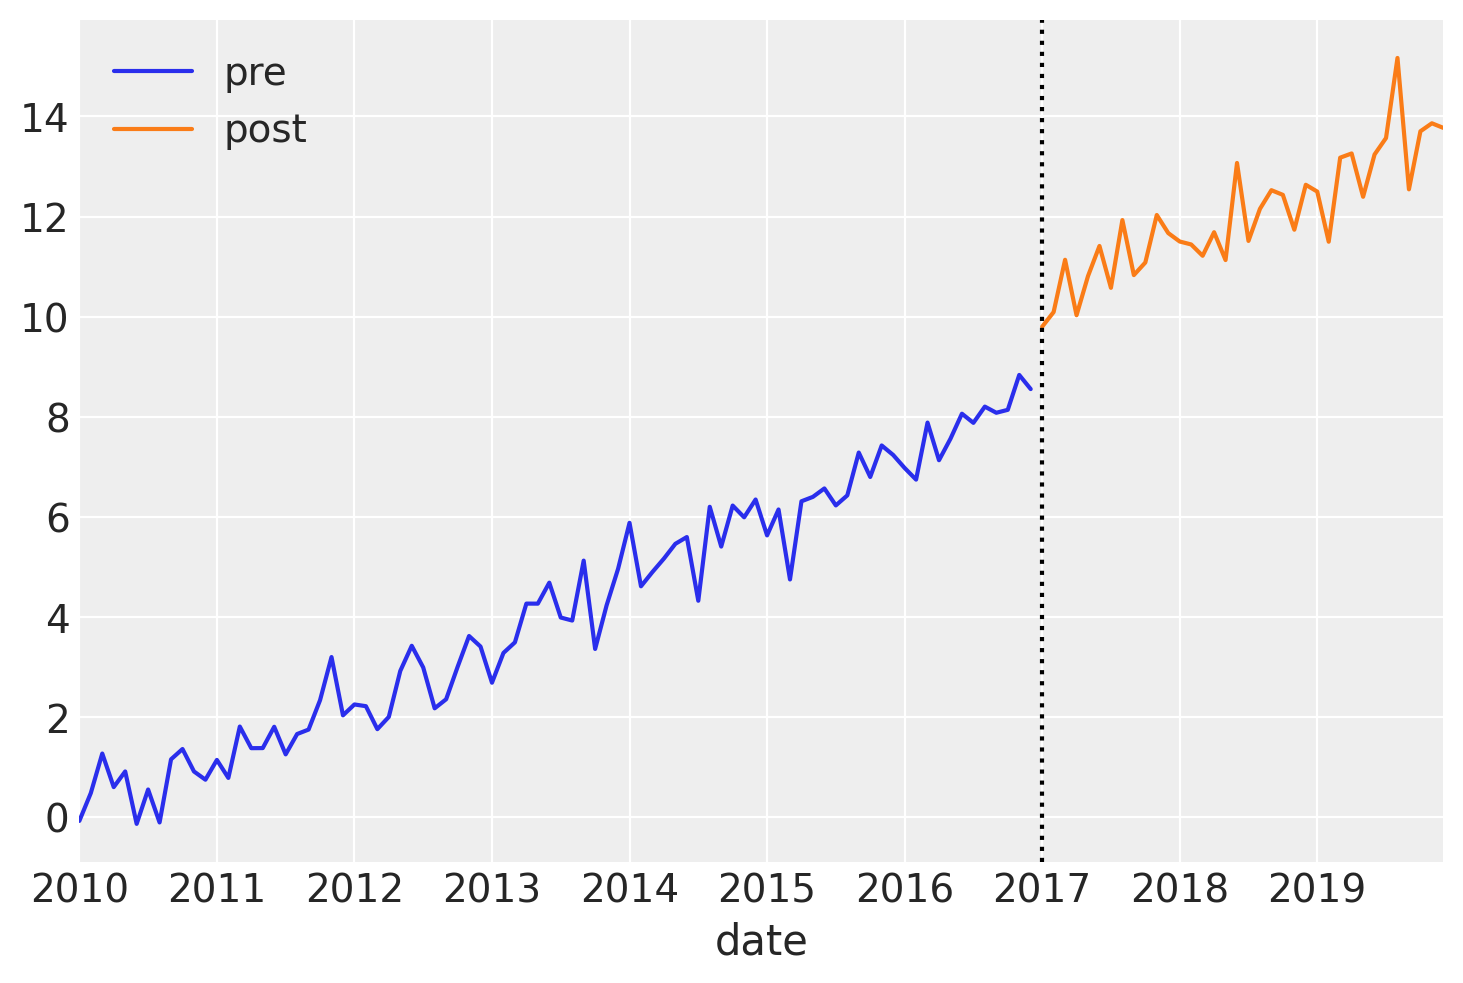

In [6]:
fig, ax = plt.subplots()
ax = pre["y"].plot(label="pre")
post["y"].plot(ax=ax, label="post")
ax.axvline(treatment_time, c="k", ls=":")
plt.legend();

In [7]:
with pm.Model() as model:
    # observed predictors and outcome
    time = pm.MutableData("time", pre["time"].to_numpy(), dims="obs_id")
    # priors
    beta0 = pm.Normal("beta0", 0, 1)
    beta1 = pm.Normal("beta1", 0, 0.2)
    # the actual linear model
    mu = pm.Deterministic("mu", beta0 + (beta1 * time), dims="obs_id")
    sigma = pm.HalfNormal("sigma", 2)
    # likelihood
    pm.Normal("obs", mu=mu, sigma=sigma, observed=pre["y"].to_numpy(), dims="obs_id")

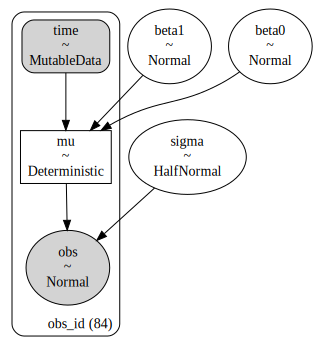

In [8]:
pm.model_to_graphviz(model)

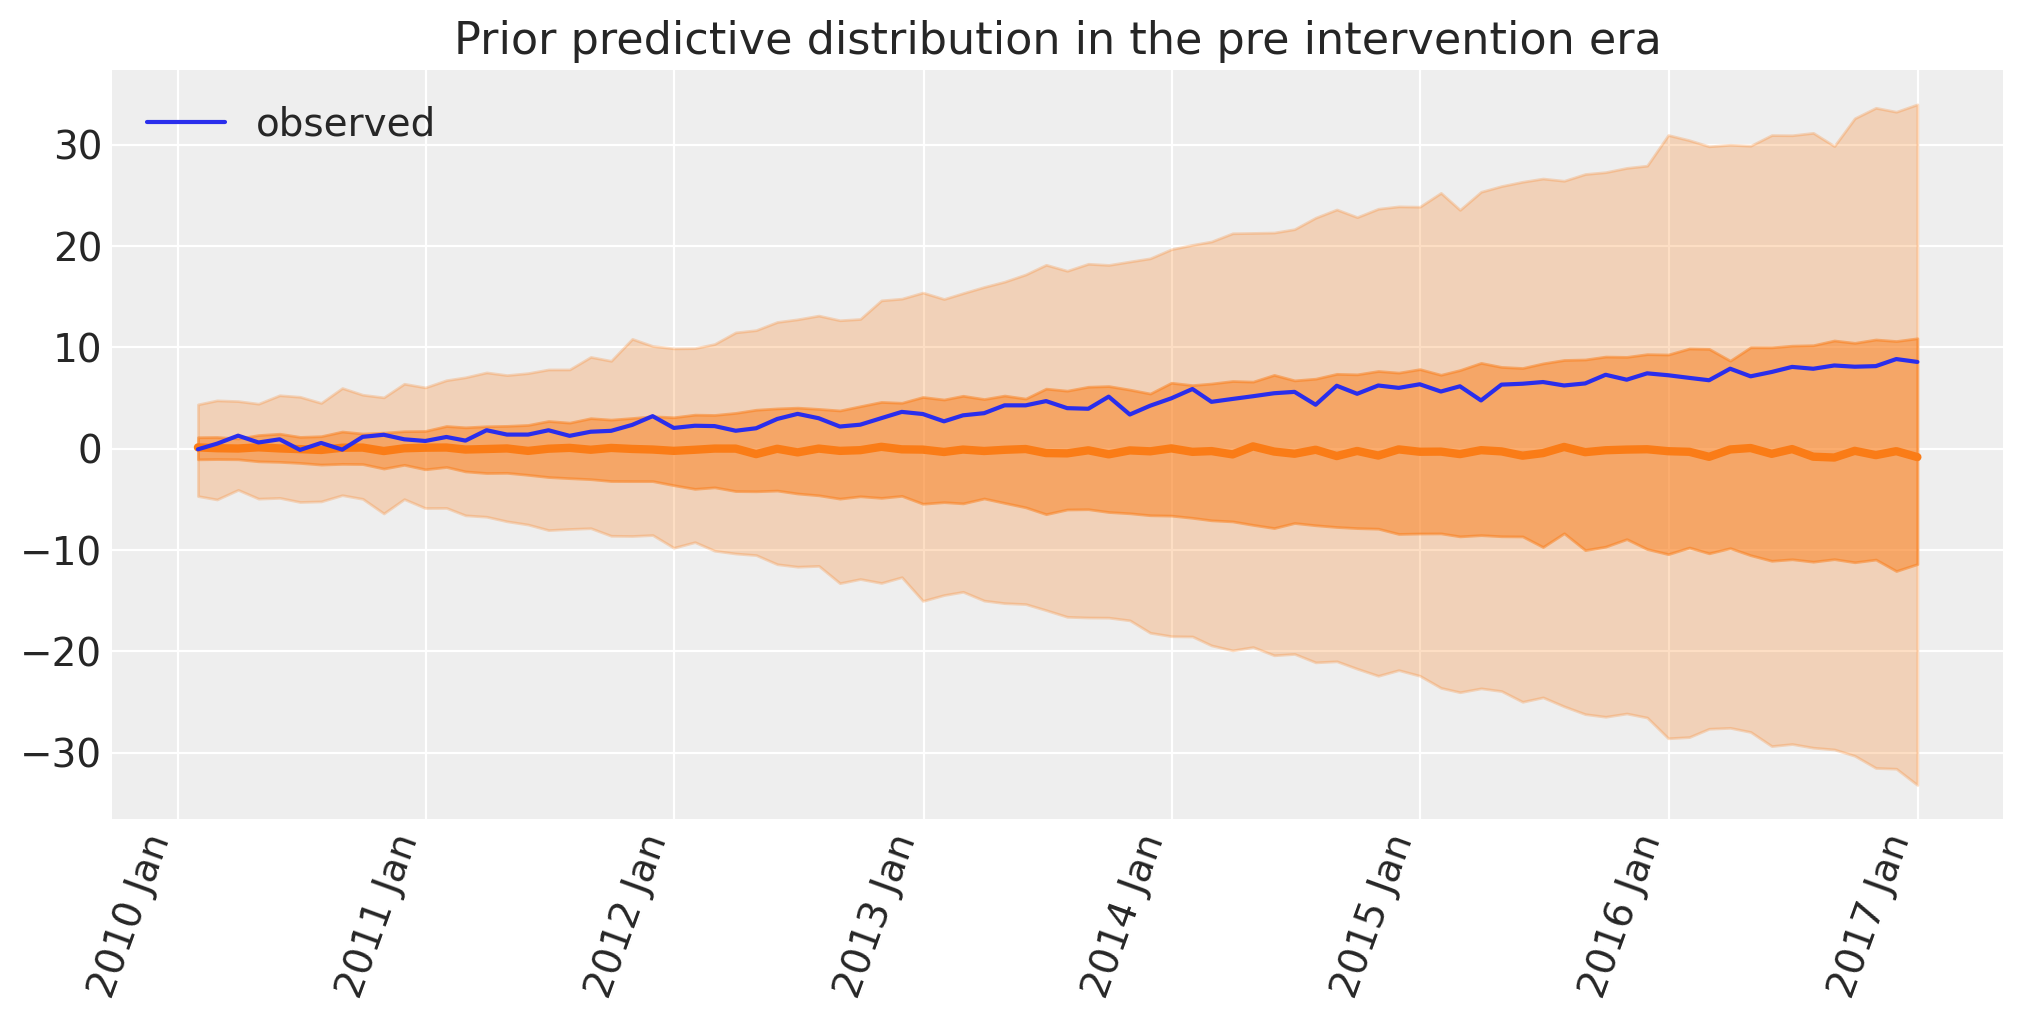

In [9]:
with model:
    idata = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

fig, ax = plt.subplots(figsize=figsize)

plot_xY(pre.index, idata.prior_predictive["obs"], ax)
format_x_axis(ax)
ax.plot(pre.index, pre["y"], label="observed")
ax.set(title="Prior predictive distribution in the pre intervention era")
plt.legend();

In [10]:
with model:
    idata.extend(pm.sample(random_seed=RANDOM_SEED))

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


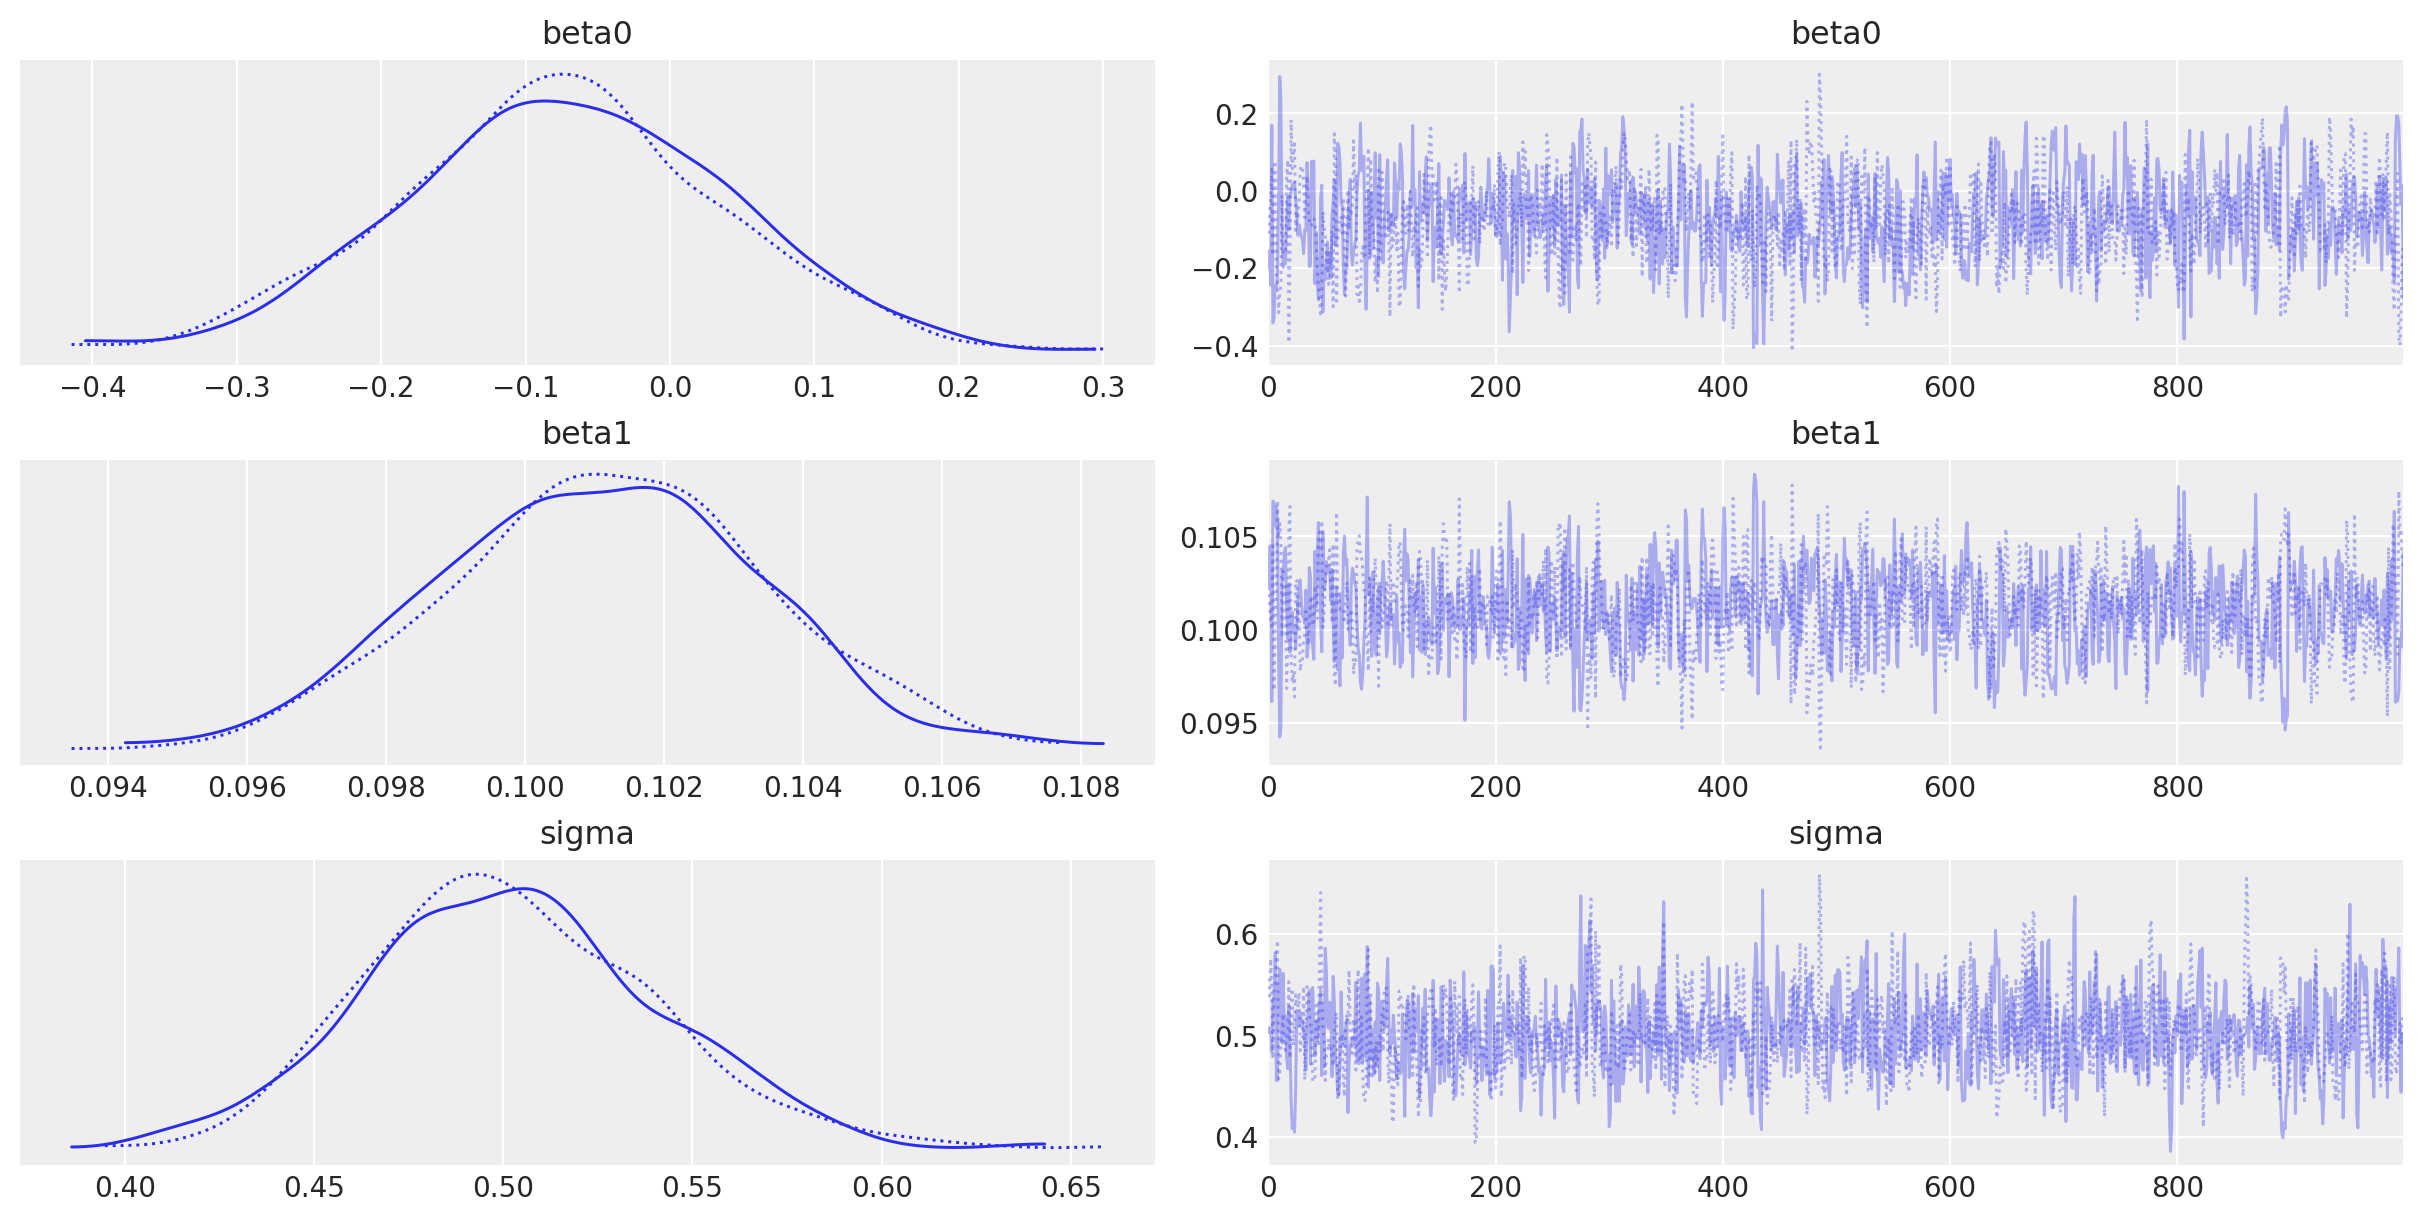

In [11]:
az.plot_trace(idata, var_names=["~mu"]);

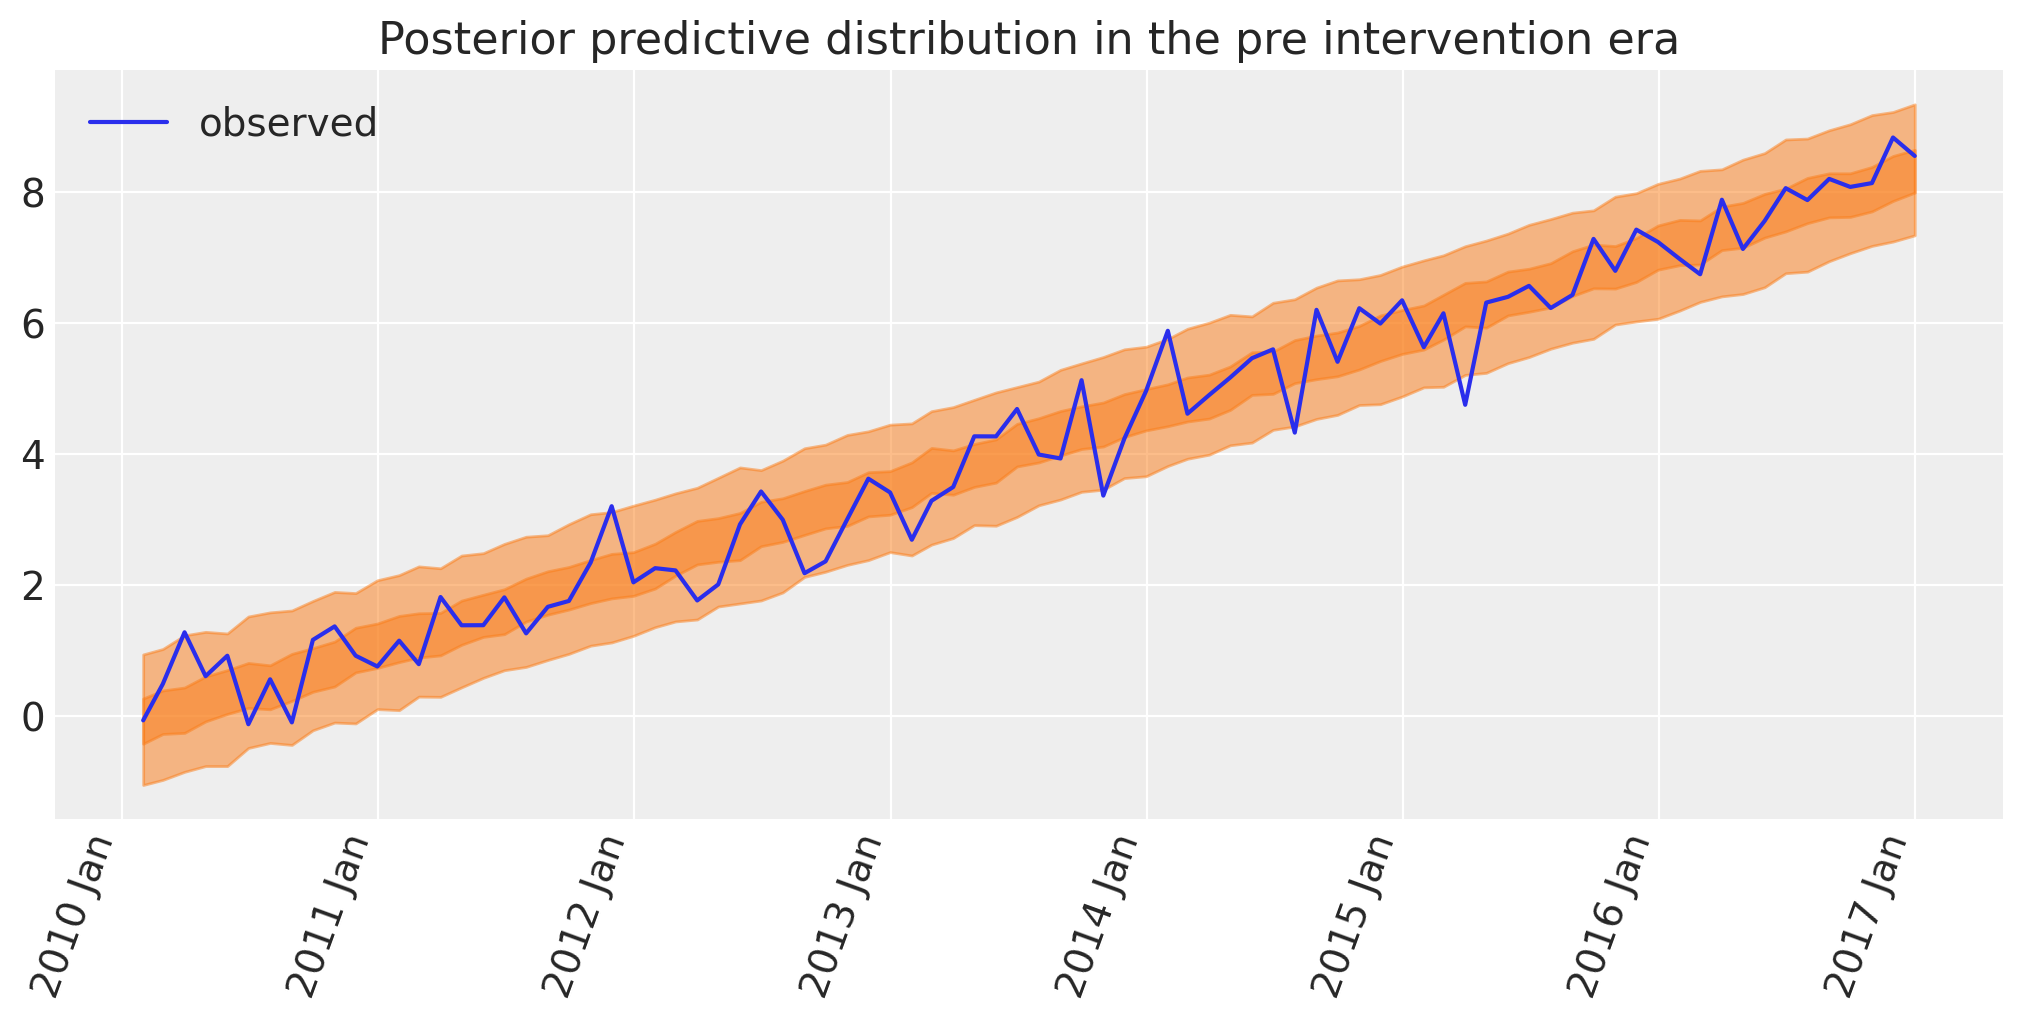

In [12]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED))

fig, ax = plt.subplots(figsize=figsize)

az.plot_hdi(pre.index, idata.posterior_predictive["obs"], hdi_prob=0.5, smooth=False)
az.plot_hdi(pre.index, idata.posterior_predictive["obs"], hdi_prob=0.95, smooth=False)
ax.plot(pre.index, pre["y"], label="observed")
format_x_axis(ax)
ax.set(title="Posterior predictive distribution in the pre intervention era")
plt.legend();

In [13]:
# convert outcome into an XArray object with a labelled dimension to help in the next step
y = xr.DataArray(pre["y"].to_numpy(), dims=["obs_id"])

# do the calculation by taking the difference
excess = y - idata.posterior_predictive["obs"]

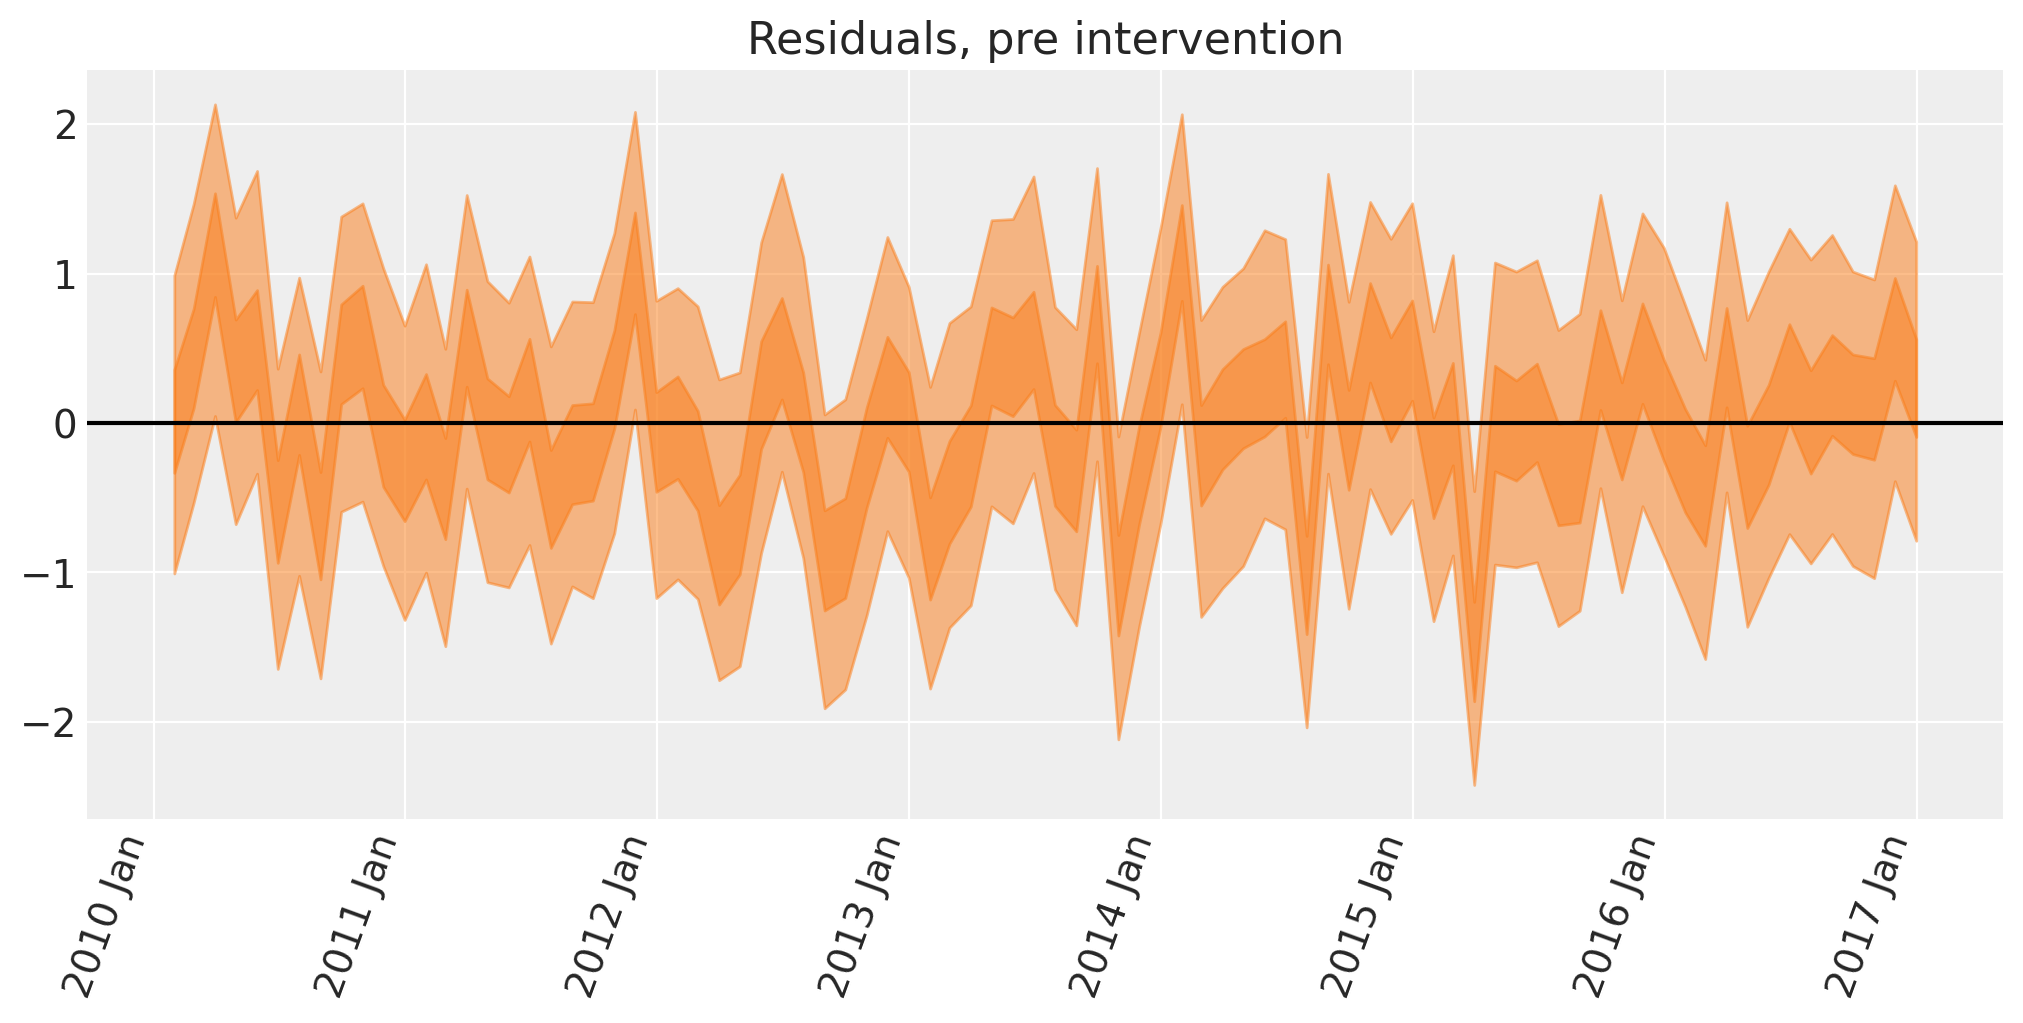

In [14]:
fig, ax = plt.subplots(figsize=figsize)
# the transpose is to keep arviz happy, ordering the dimensions as (chain, draw, time)
az.plot_hdi(pre.index, excess.transpose(..., "obs_id"), hdi_prob=0.5, smooth=False)
az.plot_hdi(pre.index, excess.transpose(..., "obs_id"), hdi_prob=0.95, smooth=False)
format_x_axis(ax)
ax.axhline(y=0, color="k")
ax.set(title="Residuals, pre intervention");

In [15]:
with model:
    pm.set_data(
        {
            "time": post["time"].to_numpy(),
        }
    )
    counterfactual = pm.sample_posterior_predictive(
        idata, var_names=["obs"], random_seed=RANDOM_SEED
    )

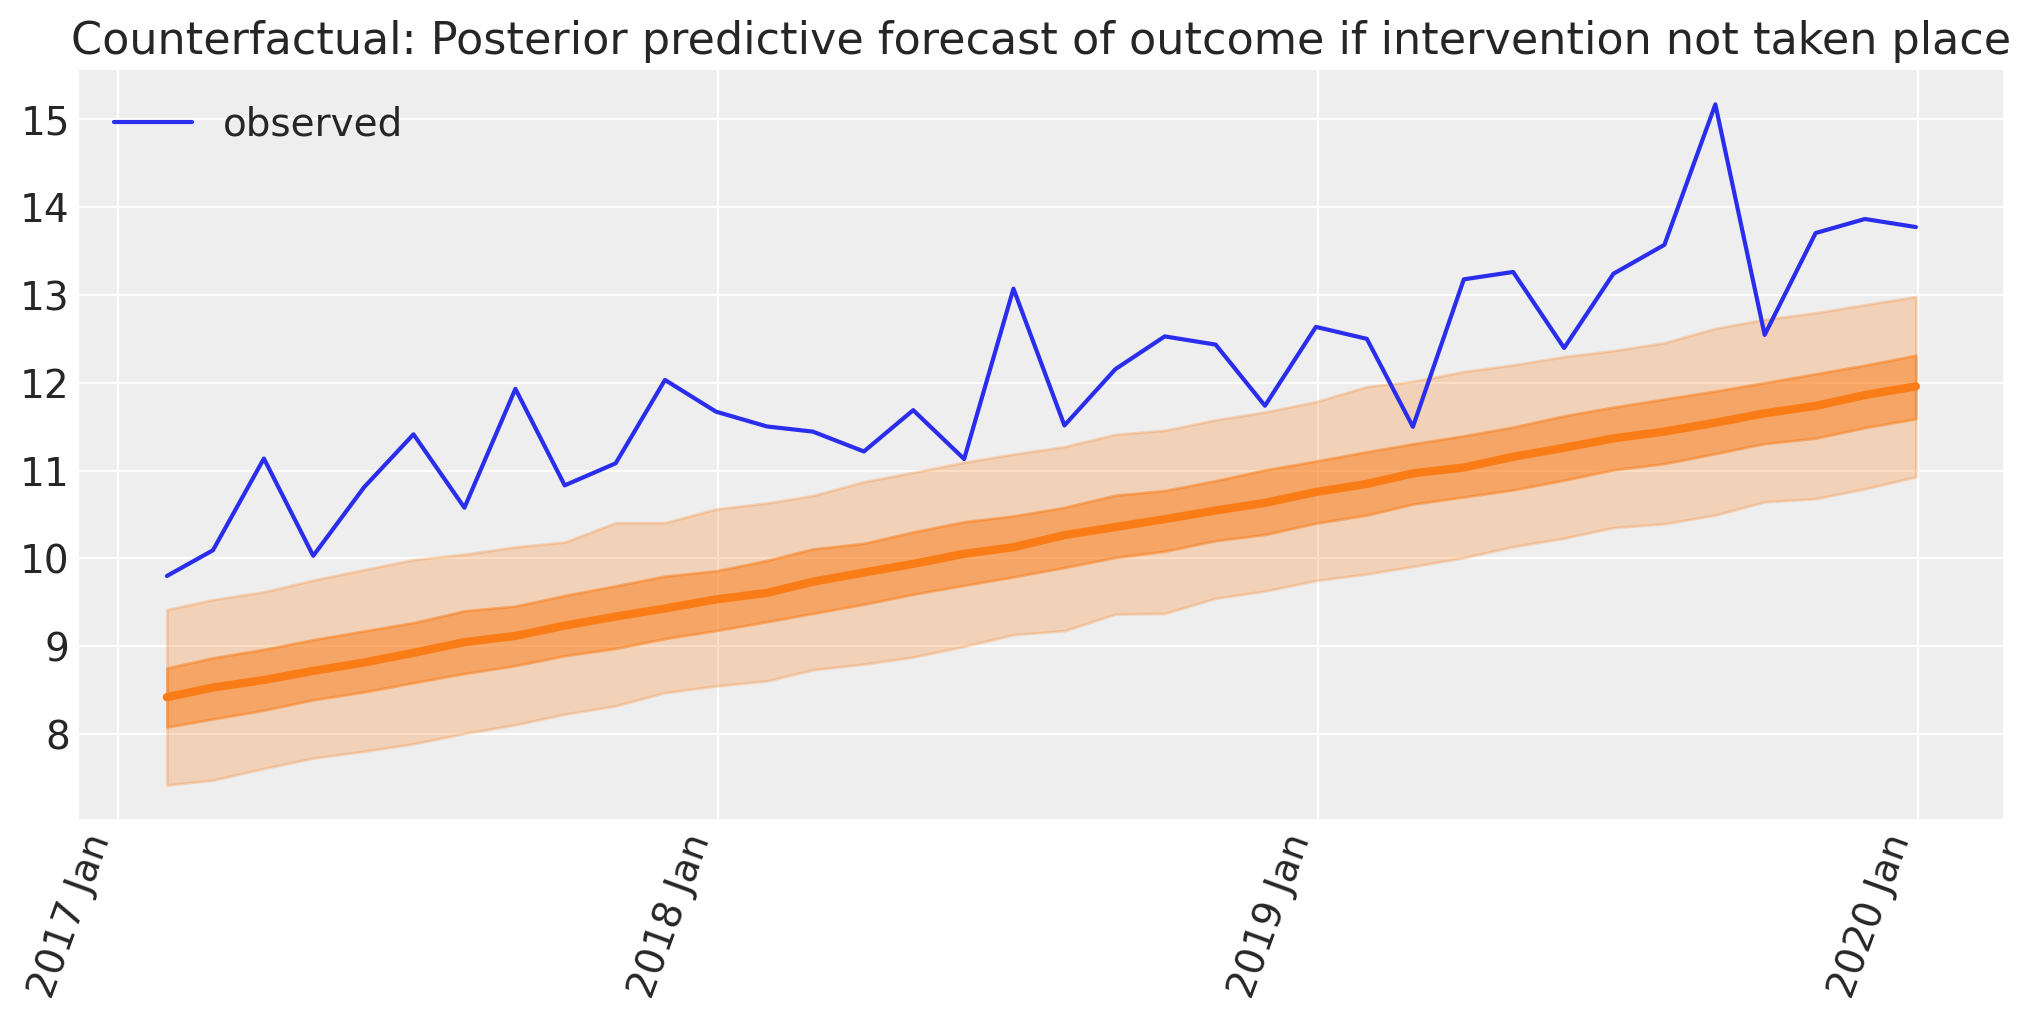

In [16]:
fig, ax = plt.subplots(figsize=figsize)

plot_xY(post.index, counterfactual.posterior_predictive["obs"], ax)
format_x_axis(ax, minor=False)
ax.plot(post.index, post["y"], label="observed")
ax.set(
    title="Counterfactual: Posterior predictive forecast of outcome if intervention not taken place"
)
plt.legend();

In [17]:
# convert outcome into an XArray object with a labelled dimension to help in the next step
outcome = xr.DataArray(post["y"].to_numpy(), dims=["obs_id"])

# do the calculation by taking the difference
excess = outcome - counterfactual.posterior_predictive["obs"]

In [18]:
# calculate the cumulative causal impact
cumsum = excess.cumsum(dim="obs_id")

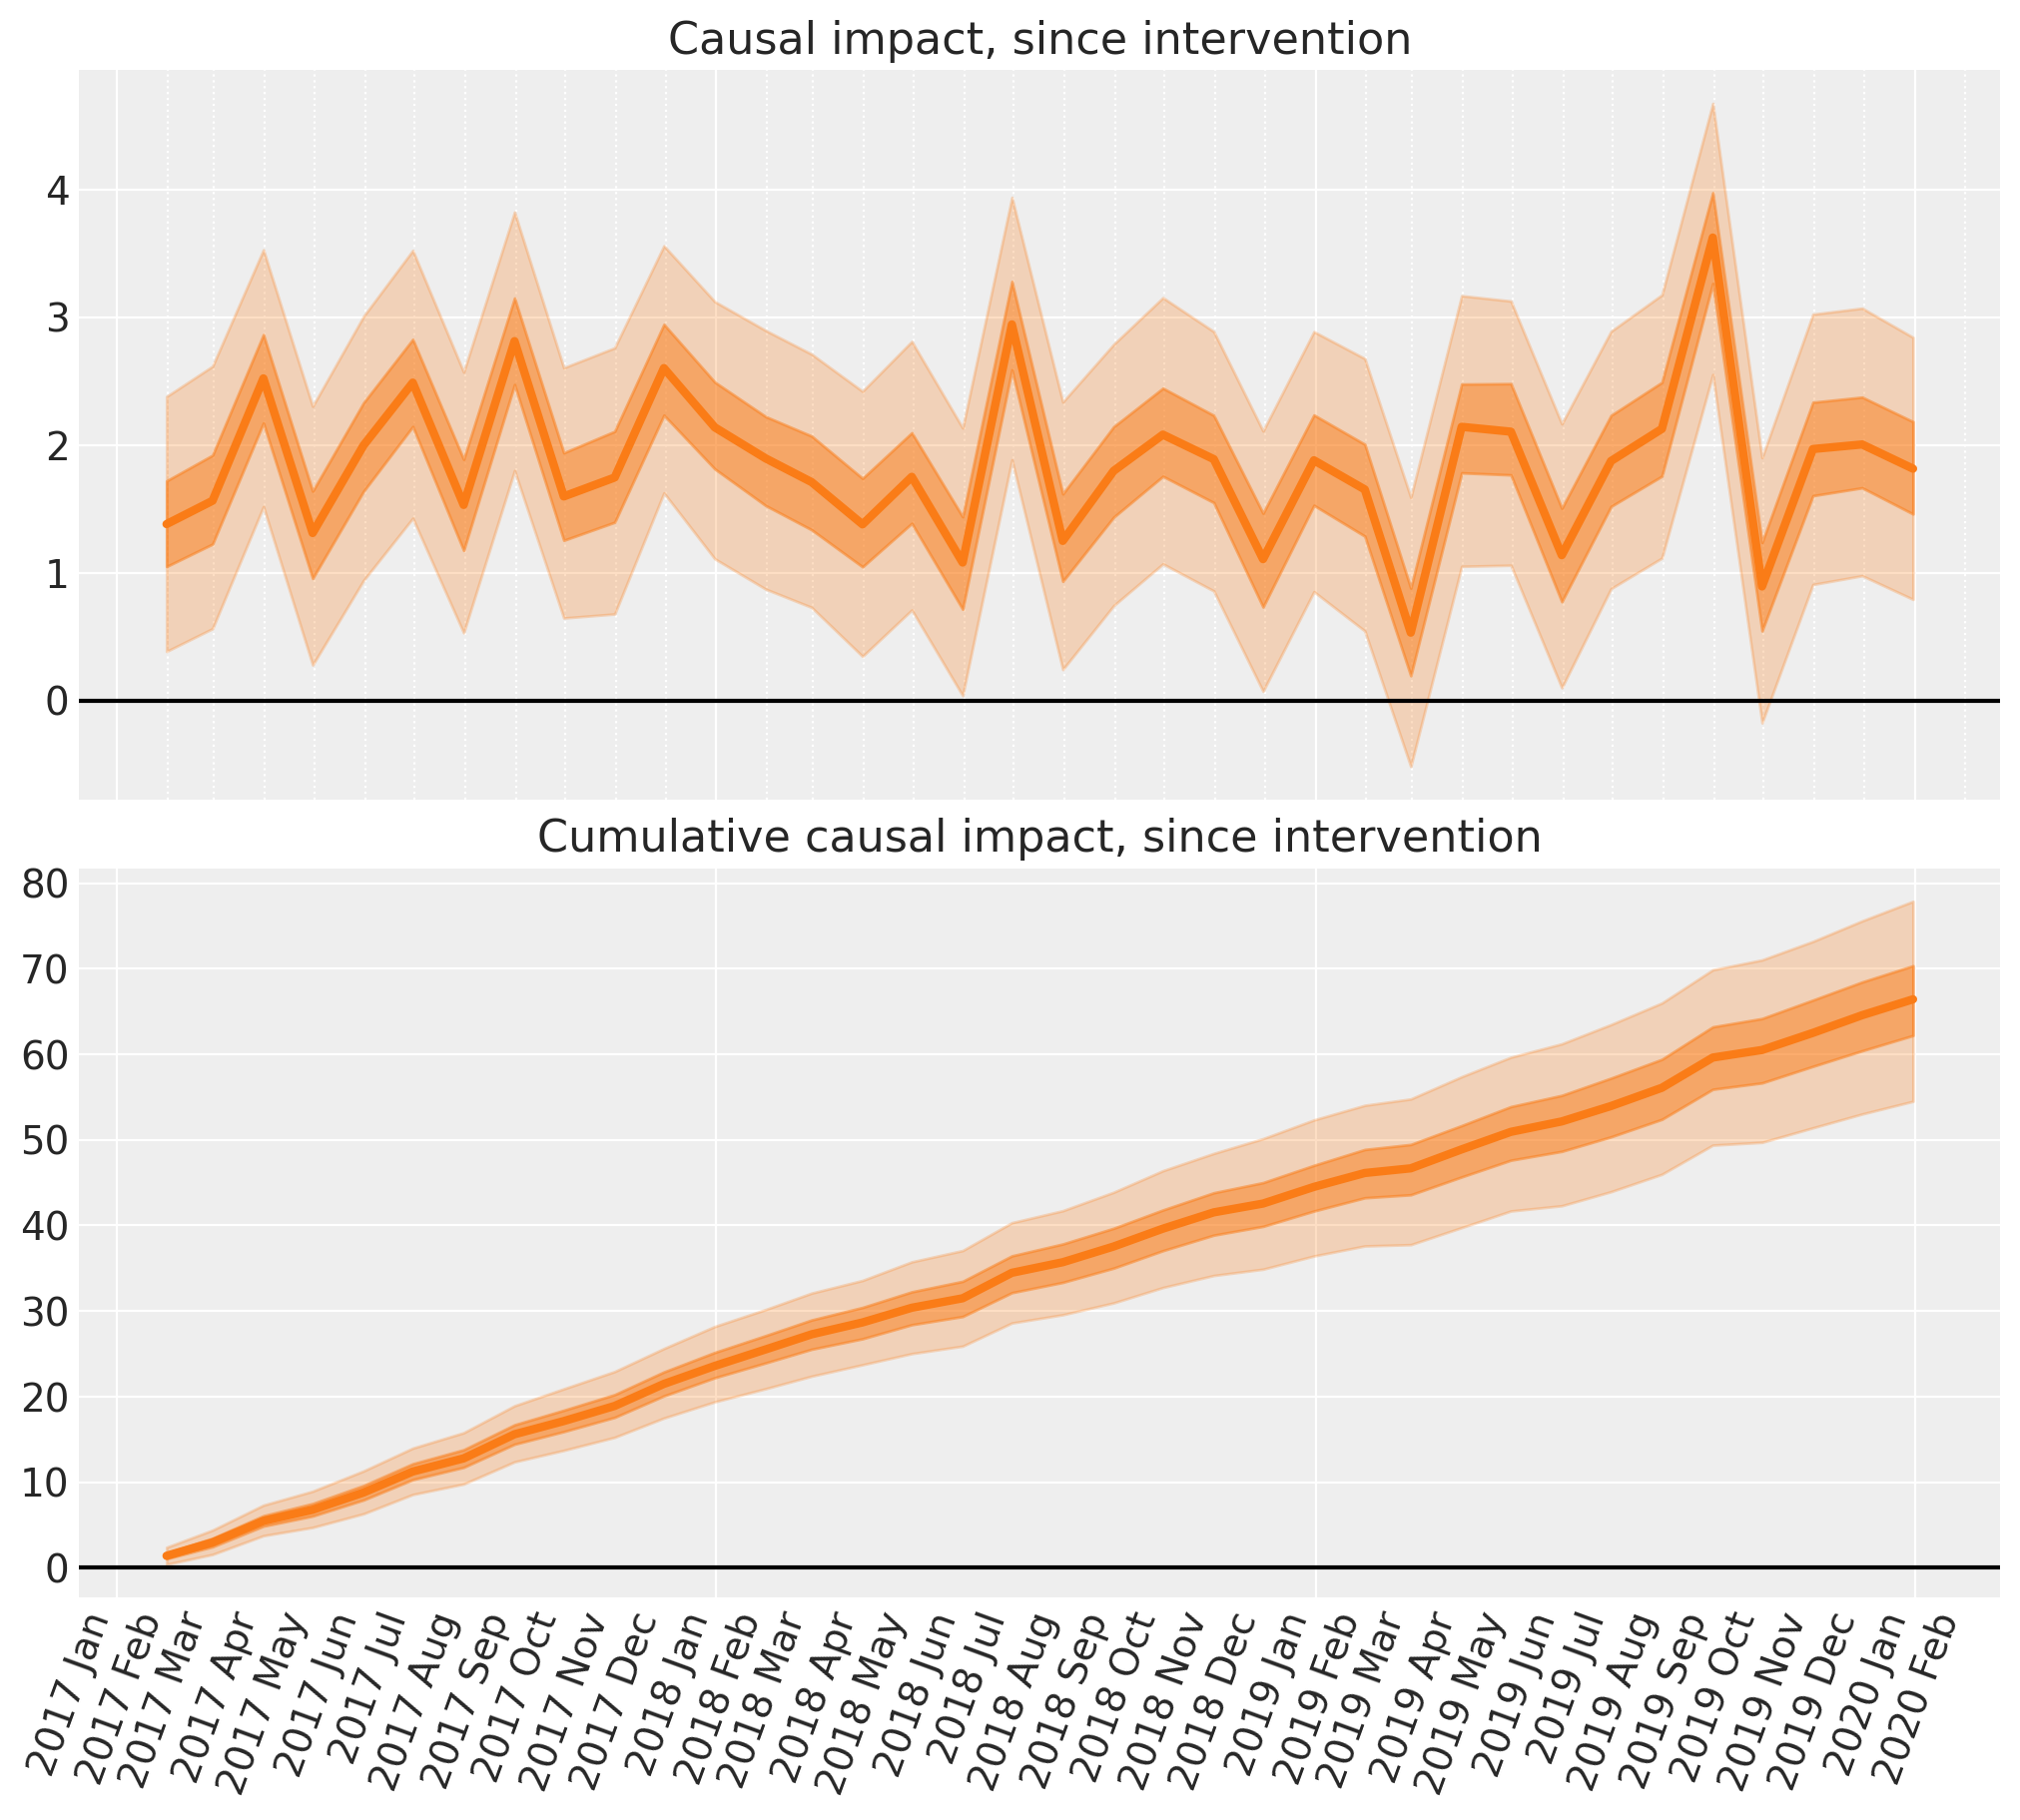

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(figsize[0], 9), sharex=True)

# Plot the excess
# The transpose is to keep arviz happy, ordering the dimensions as (chain, draw, t)
plot_xY(post.index, excess.transpose(..., "obs_id"), ax[0])
format_x_axis(ax[0], minor=True)
ax[0].axhline(y=0, color="k")
ax[0].set(title="Causal impact, since intervention")

# Plot the cumulative excess
plot_xY(post.index, cumsum.transpose(..., "obs_id"), ax[1])
format_x_axis(ax[1], minor=False)
ax[1].axhline(y=0, color="k")
ax[1].set(title="Cumulative causal impact, since intervention");

In [20]:
!pip install watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.0 MB/s eta 0:00:00


In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Fri Dec 15 2023

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

pytensor: 2.14.2
aeppl   : not installed
xarray  : 2023.7.0

matplotlib: 3.7.1
numpy     : 1.23.5
xarray    : 2023.7.0
arviz     : 0.15.1
pandas    : 1.5.3
pymc      : 5.7.2

Watermark: 2.4.3

